#**Testing Fine Tuned Model Notebook 3**

* In notebook 2 we fine tuned LLAMA-2 model on our custom Toxicity classification dataset from twitter and pushed the fine tuned model to Hugging face

* In this notebook we will be importing the model and checking its performace on test data using different evaluation matrices

In [ ]:
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7

import os
import pandas as pd
import numpy as np
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 MB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 65.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 50.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.1 MB/s eta 0:00:00


# Loading Quantized model from Hugging Face

* In this section we load our fined tuned qunatized model using bits and bytes. Similiar to the previous note. All the parameters are the same.

In [ ]:
model_name = 'Essacheez/Llama-2-7b-chat-finetune'
# Activate 4-bit precision base model loading
use_4bit = True

bnb_4bit_compute_dtype = "float16"

bnb_4bit_quant_type = "nf4"

use_nested_quant = False

device_map = {"": 0}


compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

!huggingface-cli login

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) y
Token is valid (permission: read).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credent

config.json:   0%|          | 0.00/632 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/174 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/434 [00:00<?, ?B/s]

# Loading the test dataset

* Here we are laoding the test dataset from drive. The format of the test data set is the same as train data.



In [ ]:
from google.colab import drive
from datasets import Dataset
drive.mount('/content/drive')

path = '/content/drive/My Drive/LLMS Fine tuning/test_data.csv'
dataset = pd.read_csv(path)
dataset['Answer'] = ''

Mounted at /content/drive


# Generating the predictions

* We feed the data to pipeline. The max output length is set to 350 to avoid long generation time.

* Some of the inputs them selfs have lengths greater then 500 tokens hence there output will be partially generated which we will remove in the upcoming cells

* In this cell as opposed to the traing we are feeding the input text to the pipele individuallay and storing the predictions in an array

* Please note that in testing phase we are only evaluating the model on 350 samples 50 belonging to each class. While the last 50 belonging to none of the class. This was done to accomodate for the lack of computation units availble and reduce the testing time.



In [ ]:
logging.set_verbosity(logging.CRITICAL)

counter = 0

for each_query in dataset['text']:

  if counter % 10 == 0:
    print(counter)

  prompt = each_query
  pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length= 350)
  result = pipe(f"<s>[INST] {prompt} [/INST]")
  dataset['Answer'][counter] = result[0]['generated_text'].rstrip()
  counter += 1


dataset


0


<ipython-input-11-8798d6e54977>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Answer'][counter] = result[0]['generated_text'].rstrip()


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340


,Unnamed: 0,text,Answer
0,0,<s>[INST]Recognize the Sentiment Polarity of t...,<s>[INST] <s>[INST]Recognize the Sentiment Pol...
1,1,<s>[INST]Recognize the Sentiment Polarity of t...,<s>[INST] <s>[INST]Recognize the Sentiment Pol...
2,2,<s>[INST]Recognize the Sentiment Polarity of t...,<s>[INST] <s>[INST]Recognize the Sentiment Pol...
3,3,<s>[INST]Recognize the Sentiment Polarity of t...,<s>[INST] <s>[INST]Recognize the Sentiment Pol...
4,4,<s>[INST]Recognize the Sentiment Polarity of t...,<s>[INST] <s>[INST]Recognize the Sentiment Pol...
...,...,...,...
345,345,<s>[INST]Recognize the Sentiment Polarity of t...,<s>[INST] <s>[INST]Recognize the Sentiment Pol...
346,346,<s>[INST]Recognize the Sentiment Polarity of t...,<s>[INST] <s>[INST]Recognize the Sentiment Pol...
347,347,<s>[INST]Recognize the Sentiment Polarity of t...,<s>[INST] <s>[INST]Recognize the Sentiment Pol...
348,348,<s>[INST]Recognize the Sentiment Polarity of t...,<s>[INST] <s>[INST]Recognize the Sentiment Pol...


#**Cleaning the output**

* Since the output is of the following format
   
  Toxic : 1
  Severaly toxic : 0
  Obscene: 1
  Threat: 0
  Insult: 1

  we need to extract the values of the output.

* The following 2 cells extract the values from the output. It also takes into consideration that the model might generate some send and start of sentence token too also adjusts for them accordingly

* The Splitted output is displayed below



In [ ]:

def clean_data(prediction):

  start = prediction.find('[/INST] [/INST]')+len('[/INST] [/INST]')
  string_edit = prediction[start:]
  endstring = string_edit.find('Identity Hate:') + len('Identity Hate: 0')
  string_edit2 = string_edit[:endstring]
  return string_edit2.split()

print(clean_data(dataset['Answer'][200]))


['Toxic', ':', '1', 'Severaly', 'toxic', ':', '1', 'Obscene:', '1', 'Threat:', '0', 'Insult:', '1', 'Identity', 'Hate:', '0']


In [ ]:
dataset['Pred_Toxic'] = ""
dataset['Pred_Sev_Toxic'] = ""
dataset['Pred_obscene'] = ""
dataset['Pred_thread'] = ""
dataset['Pred_insult'] = ""
dataset['Pred_hate'] = ""

for index, each in enumerate(dataset['Answer']):
    predictions = clean_data(each)
    if len(predictions) == 16:
        dataset.loc[index, 'Pred_Toxic'] = predictions[2]
        dataset.loc[index, 'Pred_Sev_Toxic'] = predictions[6]
        dataset.loc[index, 'Pred_obscene'] = predictions[8]
        dataset.loc[index, 'Pred_thread'] = predictions[10]
        dataset.loc[index, 'Pred_insult'] = predictions[12]
        dataset.loc[index, 'Pred_hate'] = predictions[15]

# Drop rows with null values in 'Pred_hate' column

dataset = dataset.drop(dataset[dataset['Pred_Toxic'] == ""].index)
dataset

,Unnamed: 0,text,Answer,Pred_Toxic,Pred_Sev_Toxic,Pred_obscene,Pred_thread,Pred_insult,Pred_hate
0,0,<s>[INST]Recognize the Sentiment Polarity of t...,<s>[INST] <s>[INST]Recognize the Sentiment Pol...,1,0,0,0,1,1
1,1,<s>[INST]Recognize the Sentiment Polarity of t...,<s>[INST] <s>[INST]Recognize the Sentiment Pol...,1,0,1,1,0,0
2,2,<s>[INST]Recognize the Sentiment Polarity of t...,<s>[INST] <s>[INST]Recognize the Sentiment Pol...,1,1,1,0,1,0
3,3,<s>[INST]Recognize the Sentiment Polarity of t...,<s>[INST] <s>[INST]Recognize the Sentiment Pol...,1,0,1,0,1,1
5,5,<s>[INST]Recognize the Sentiment Polarity of t...,<s>[INST] <s>[INST]Recognize the Sentiment Pol...,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...
342,342,<s>[INST]Recognize the Sentiment Polarity of t...,<s>[INST] <s>[INST]Recognize the Sentiment Pol...,1,0,1,0,1,1
344,344,<s>[INST]Recognize the Sentiment Polarity of t...,<s>[INST] <s>[INST]Recognize the Sentiment Pol...,1,0,1,0,0,0
346,346,<s>[INST]Recognize the Sentiment Polarity of t...,<s>[INST] <s>[INST]Recognize the Sentiment Pol...,1,0,1,0,1,0
347,347,<s>[INST]Recognize the Sentiment Polarity of t...,<s>[INST] <s>[INST]Recognize the Sentiment Pol...,1,0,1,0,1,0


#Importing Test Lables Data


In [ ]:
path = '/content/drive/My Drive/LLMS Fine tuning/test_lables.csv'
test_lables = pd.read_csv(path)
test_lables
common_indexes = dataset.index.intersection(test_lables.index)
#remove from lables that are not in 1
test_lables= test_lables[test_lables.index.isin(common_indexes)]
test_lables


,Unnamed: 0,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,text
0,0,349b3f8f7754f1cc,""" You're a dumb American, right? No degree? Kn...",1,0,0,0,0,0,<s>[INST]Recognize the Sentiment Polarity of t...
1,1,73b38c06fae69b1b,EAT CRAP AND DIE!!!!!,1,0,1,1,1,0,<s>[INST]Recognize the Sentiment Polarity of t...
2,2,0f0f2b97146a7182,"look here you small penis faggot, you better w...",1,0,1,1,1,0,<s>[INST]Recognize the Sentiment Polarity of t...
3,3,970f0e85d113b8f6,your gay douche like gay porno ahaghagagagaa,1,0,1,0,1,1,<s>[INST]Recognize the Sentiment Polarity of t...
5,5,a555ec0b45c8712c,You are a total fool; Joseph Smith is the big...,1,0,0,0,1,1,<s>[INST]Recognize the Sentiment Polarity of t...
...,...,...,...,...,...,...,...,...,...,...
342,342,70660101f2ba447c,Well you know what? You're a faggot too! What\...,1,1,1,0,1,1,<s>[INST]Recognize the Sentiment Polarity of t...
344,344,91630183539cca60,"""\nThe Graceful Slick....\nIs non other than a...",1,0,1,0,1,0,<s>[INST]Recognize the Sentiment Polarity of t...
346,346,54b5ef80b87225f7,"Holy Crap ==\n\nI have an account, blocking my...",1,0,1,0,0,0,<s>[INST]Recognize the Sentiment Polarity of t...
347,347,9e1ae3198f36411c,"Fred, shut up you sad old twat, no one is inte...",1,0,1,0,1,1,<s>[INST]Recognize the Sentiment Polarity of t...


#Evaluating the Output using multi_label confusion Matrix 🧪

* For evaluating the output of the model we use Sk-learn multilabel confusion matrix.

* Please note that

* Since the data is highly unbalanced during training in addition to the accuracy of the models we use measures like Precision, Recall, F1 and micro/macro averaging.

* Despite training the model for 400-1000 examples of each class model shows exceptional performace on the testing set.

* The precisions and recalls for almost all the classes except threat class are between 80-90. Addtionally the accuracy of the testing is equal to 90%. In this case we can consider the accuracy because the testing case contained 50 exaples from each side.

* These results are better then all of our previous models.

* The relativly bad performace of the model on Threat class is due to the fact that the traning examples of threat class were less then half the number of smaples in the data set. Additionally as can be seen in confusion matrix the number of testing examples are way less then other classes.



(304, 6)
(304, 6)
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       258
           1       0.55      0.80      0.65        70
           2       0.93      0.92      0.93       202
           3       0.83      0.59      0.69        49
           4       0.88      0.93      0.90       194
           5       0.83      0.81      0.82        68

   micro avg       0.88      0.91      0.89       841
   macro avg       0.83      0.84      0.83       841
weighted avg       0.89      0.91      0.89       841
 samples avg       0.76      0.79      0.76       841

Hamming Loss: 0.1020
Test Accuracy: 0.8980263157894737
F1 Score: 0.8980263157894738


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


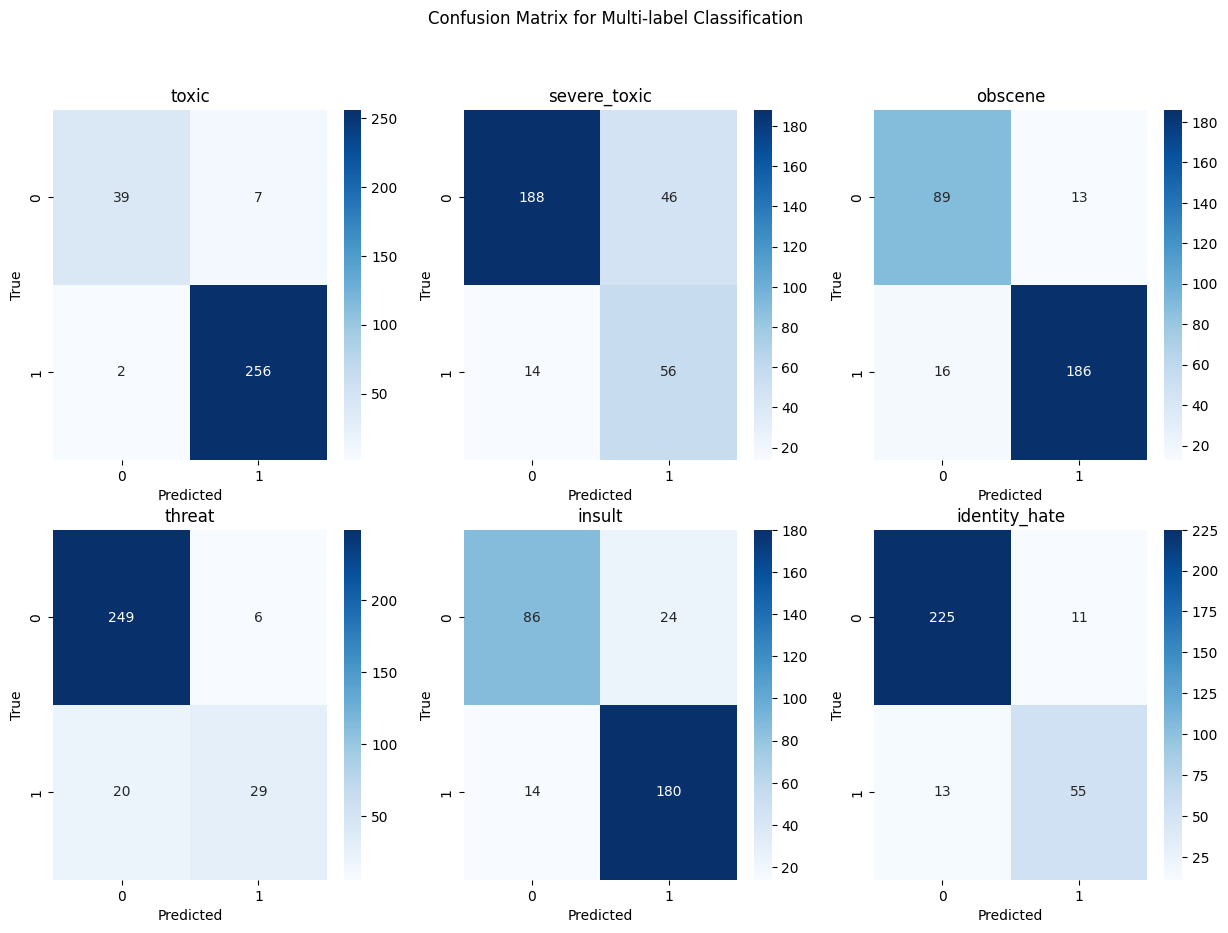

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, multilabel_confusion_matrix,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

label_df = test_lables[['toxic' ,'severe_toxic' ,  'obscene' , 'threat' ,  'insult' , 'identity_hate']]
prediction_df = dataset[['Pred_Toxic' ,'Pred_Sev_Toxic' ,  'Pred_obscene' , 'Pred_thread' ,  'Pred_insult' , 'Pred_hate']]

column_labels = list(label_df.columns)
y_test_arr = label_df.to_numpy().astype(int)
predictions = prediction_df.to_numpy().astype(int)


print(y_test_arr.shape)
print(predictions.shape)


# Get Test Accuracy, F1 Score, and Confusion Matrix
test_accuracy = accuracy_score(y_test_arr.flatten(), predictions.flatten())
f1 = f1_score(y_test_arr.flatten(), predictions.flatten(), average='micro')
conf_matrix = multilabel_confusion_matrix(y_test_arr, predictions)
from sklearn.metrics import classification_report, hamming_loss

# binary_predictions = (predictions >= 0.5).astype(int)

print("Classification Report:")
print(classification_report(y_test_arr, predictions))

hl = hamming_loss(y_test_arr, predictions)
print(f"Hamming Loss: {hl:.4f}")

print(f'Test Accuracy: {test_accuracy}')
print(f'F1 Score: {f1}')

# plot conf matrix for each label seperately
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, ax in enumerate(axes.flatten()):
    sns.heatmap(conf_matrix[i], annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(f'{column_labels[i]}')

plt.suptitle('Confusion Matrix for Multi-label Classification')
plt.show()

# ROC Curve

* The analysis focuses on the area under the receiver operating characteristic curve (AUC-ROC). The AUC-ROC is a metric used to evaluate the performance of a classification model.

* AUC-ROC quantifies the overall performance of the model by calculating the area under the ROC curve. A higher AUC value (closer to 1) indicates better discrimination between instances

* The graph indicates consistent performance within the range of 85% to 95% across all classes. The results suggest a robust predictive capability of the model, demonstrating its effectiveness in diverse categorization tasks.

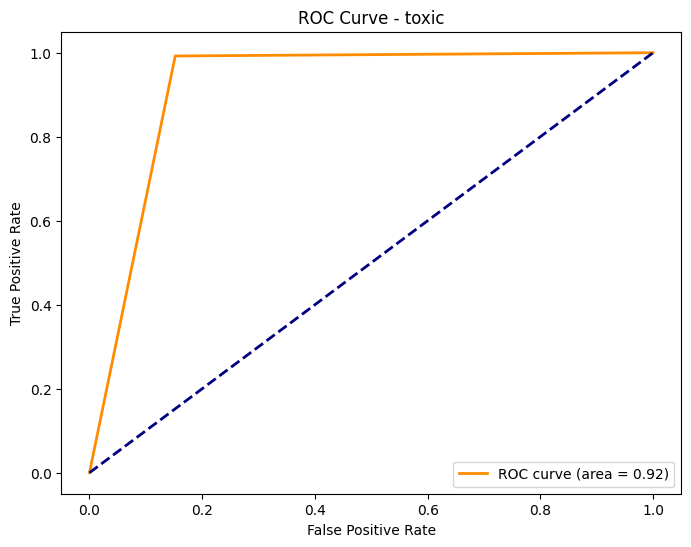

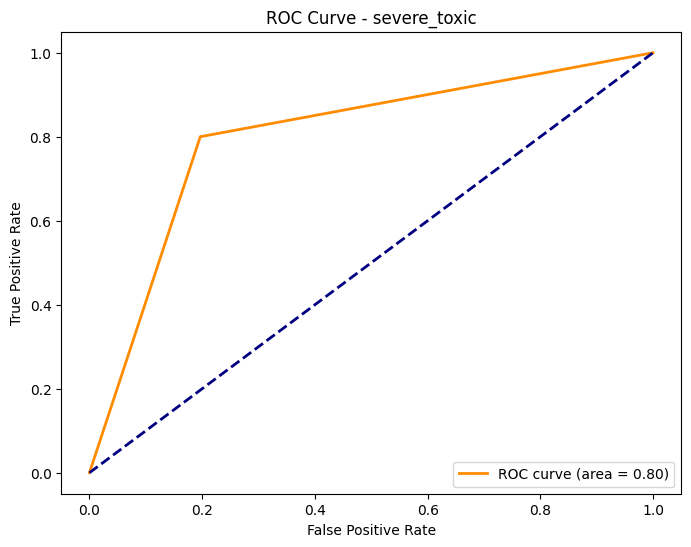

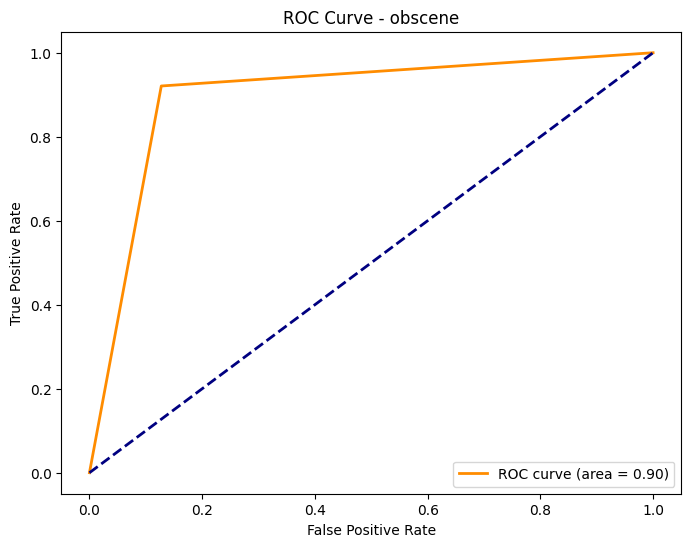

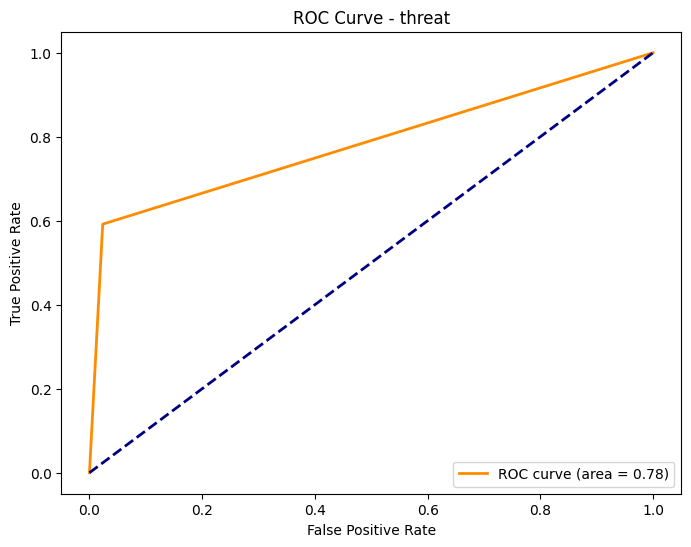

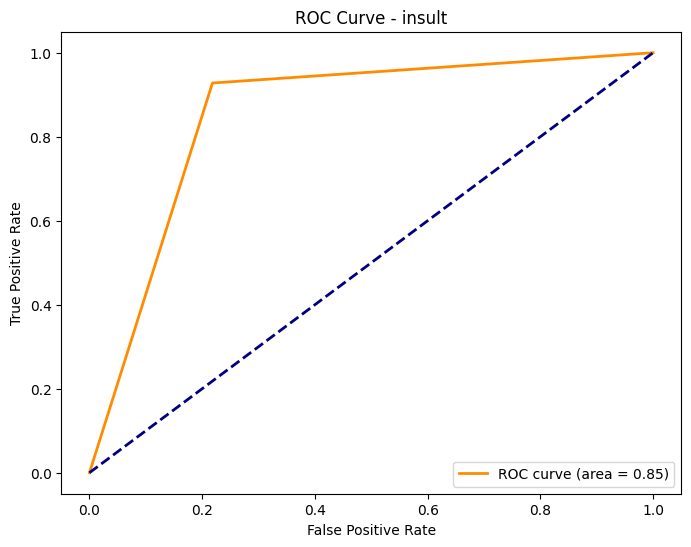

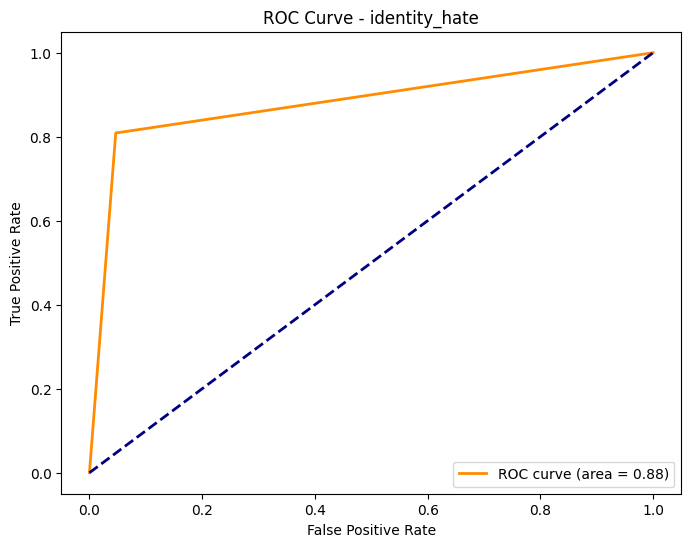

In [ ]:
from sklearn.metrics import roc_curve, auc
for i, label in enumerate(column_labels):
    fpr, tpr, _ = roc_curve(y_test_arr[:, i], predictions[:, i])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {label}')
    plt.legend(loc='lower right')
    plt.show()

#**Conculsion**

* In conclusion, this project employed advanced techniques such as Parameter Efficient Fine Tuning (PEFT) and Quantization using Bits&Bytes to enhance the performance of a language model, specifically LLAMA-2, for a toxicity classification task. The incorporation of PEFT allowed for fine-tuning specific subsets of parameters, providing a more efficient approach than traditional fine-tuning methods. Moreover, the utilization of Bits&Bytes for quantization significantly reduced GPU VRAM requirements, making it feasible to handle the substantial parameter count of LLAMA-2.

* The results of the fine-tuned model showcase exceptional accuracy, F1 scores, precision, and recall, particularly when addressing the challenges posed by imbalanced data. Notably, the model's performance in threat classification is acknowledged as an area for potential improvement, attributed to the limited number of training examples for this class. It is evident that with increased data on minority classes and further training, the model's capabilities can be optimized, promising even better results in future iterations. The deployment of techniques like Quantization and PEFT, alongside the capabilities of LLAMA-2, underscores the potential of state-of-the-art language models for complex classification tasks.

#**Future Research Directions**:

The evolving landscape of large language models (LLMs) introduces challenges in terms of model size, memory requirements, and efficient deployment. Two recent breakthroughs pave the way for exciting future research in text classification:

* **Post-Training Quantization with QuIP#**


* Recent work from Cornell introduces QuIP#, a novel approach that combines lattice codebooks with incoherence processing to achieve state-of-the-art 2-bit quantized language models. LLMs, such as Llama 2 with its 70 billion parameters, demand substantial memory resources. Post-training quantization compresses model weights into lower precision formats, significantly reducing memory requirements. For instance, QuIP# demonstrates the potential to close the gap between 2-bit quantized LLMs and unquantized 16-bit models. This breakthrough opens avenues for future research in optimizing memory-efficient deployment of large language models, potentially allowing even massive models to run on standard GPUs.

* **Mistral's Mixture of Experts (MoE) Model**


* Mistral AI's release of an MoE model, a scaled-down version of GPT-4 with 8 experts, presents an intriguing avenue for exploration. Mixture of Experts is a technique that divides complex tasks into smaller, specialized sub-tasks, each handled by an expert. Mistral's MoE model, with only 2 experts used for the inference of each token, showcases a more efficient architecture. The model achieves a significant reduction in parameters compared to GPT-4 while maintaining a comparable context size. Future research could delve into the application of MoE techniques for enhancing the efficiency and accuracy of text classification tasks. Understanding how to leverage the expertise of specialized models for different aspects of text classification and generation may lead to significant advances in text classification particulary on hard datsets like Toxicity classification


In summary, these breakthroughs in post-training quantization and MoE architectures provide exciting prospects for advancing text classification models, addressing challenges posed by large model sizes and paving the way for more memory-efficient and specialized language models

#**THE END** 🚧